In [301]:
import sys
import os
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import time

def L99_thickness(filename_prefix,t):
    fname = filename_prefix+'L99.dat'
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)

    nstats=2
    dat = np.reshape(dat,[n/nstats,nstats])
    time = dat[:,0]
    L99 = dat[:,1]
    
    idx = np.argmin(abs(time-t))
    return L99[idx]    

xdir=0; ydir=1; zdir=2;

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/256x512x128/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/512x724x256/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr7/256x512x128/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/256x512x128/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/256x512x128/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/512x724x256/'
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/1024x1024x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1024x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr_7/1024x1024x512/'

# directory = "/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/724x724x256/"
# directory = "/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1024x512/"

filename_prefix = directory+'/shearlayer_'
reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
Nx,Ny,Nz,Lx,Ly,Lz,dx,dy,dz,kx,kz = stats.domain(reader,verbose=1)
x, y, z = reader.readCoordinates()
xplot = np.squeeze(x[:,0,0])
yplot = np.squeeze(y[0,:,0])
zplot = np.squeeze(z[0,0,:])
steps = sorted(reader.steps)
print("Steps: {}".format(reader.steps))

Domain size: 100.0 x 99.90234375 x 50.0
Grid size: 1024 x 1024 x 512
Grid res: 0.09765625 x 0.09765625 x 0.09765625
Steps: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 5069)


Time: 750.0


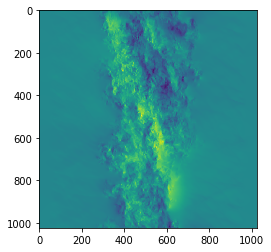

In [302]:
reader.step = 15
print("Time: {}".format(reader.time))

# Get fluctuations
u = reader.readData('u')
u = np.squeeze(np.array(u))
U = np.mean(np.mean(u,axis=zdir),axis=xdir)
up = np.zeros(np.shape(u))
for i in range(Ny-1):
    up[:,i,:] = u[:,i,:] - U[i]

plt.imshow(up[:,:,1])
# plt.imshow(up[:,Ny/2,:])

(247, 265)
Integral Ly = 25.87890625
L99 = 22.75390625
L_int/L99 = 1.13733905579


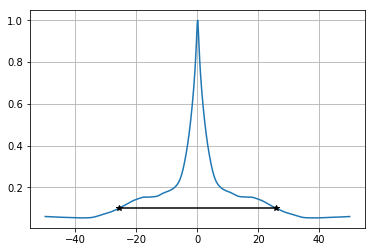

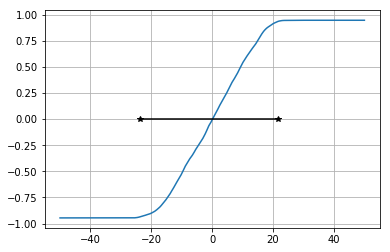

In [304]:
# Lengthscale thickness (transverse)
R11_mean = np.zeros([Ny])
for xi in range(0,Nx,10):
    for zi in range(0,Nz,10):
        uhat = np.fft.fftshift(np.fft.fft(up[xi,:,zi]))
        R11hat = uhat*np.conj(uhat)#autocorr
        R11 = np.abs(np.fft.ifft(R11hat))
        R11 = np.fft.ifftshift(R11)
        R11 /= R11.max()
        R11_mean += R11
R11_mean = R11_mean/R11_mean.max()

thresh = 0.1
i1 = np.argmin(abs(R11_mean[:Ny/2]-thresh))
i2 = np.argmin(abs(R11_mean[Ny/2:]-thresh))
L_int = abs(yplot[i1]-yplot[Ny/2+i2])/2.
print(i1,i2)
print("Integral Ly = {}".format(L_int))

plt.plot(yplot,R11_mean)
plt.plot([yplot[i1],yplot[Ny/2+i2]],[thresh,thresh],'k-*')
plt.grid(True)

# 99% Thickness

ubar = np.mean(np.mean(u,axis=zdir),axis=xdir)
du = ubar[-1]-ubar[0]
utop = 0.99*du/2
ubot = -0.99*du/2
i1 = np.argmin(abs(ubar[:Ny/2]-ubot))
i2 = np.argmin(abs(ubar[Ny/2:]-utop)) + Ny/2
L99 = (yplot[i2]-yplot[i1])/2.

plt.figure()
plt.plot(yplot,ubar)
plt.plot([yplot[i1],yplot[i2]],[0,0],'k-*')
plt.grid(True)
print("L99 = {}".format(L99))
print("L_int/L99 = {}".format(L_int/L99))

Text(0,0.5,'$L/\\delta_{99}$')

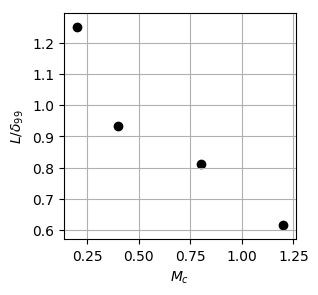

In [293]:
ly_norm = {
    0.2: 1.25, #256x512, step 40
    #0.2, 1.08, #512x724
    0.4: 0.932, # 256x512
    0.8: 0.811, # 1024x1024, step 40
    #1.2: 0.394 # 724x724, step 10
    1.2: 0.616 # 1024x1024, step 17
}
fs = 14
fig = plt.figure(figsize=(3,3),dpi=100)
plt.scatter(ly_norm.keys(),ly_norm.values(),c='k')
plt.grid(True)
plt.xlabel(r'$M_c$')
plt.ylabel(r'$L/\delta_{99}$')


Integral Lx = 19.3359375


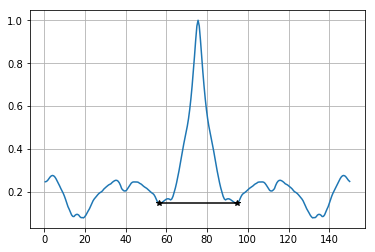

In [54]:
# Lengthscale in x at centerline

R11_mean = np.zeros([Nx])
for zi in range(0,Nz,int(Nz/10)):
    uhat = np.fft.fftshift(np.fft.fft(up[:,Ny/2,zi]))
    R11hat = uhat*np.conj(uhat)#autocorr
    R11 = np.abs(np.fft.ifft(R11hat))
    R11_mean += np.fft.ifftshift(R11)/R11.max()
R11_mean = R11_mean/R11_mean.max()

thresh = 0.15
i1 = np.argmin(abs(R11_mean[:Nx/2]-thresh))
i2 = np.argmin(abs(R11_mean[Nx/2:]-thresh)) + Nx/2
L = abs(xplot[i2]-xplot[i1])/2.
print("Integral Lx = {}".format(L))

plt.plot(xplot,R11_mean)
plt.plot([xplot[i1],xplot[i2]],[thresh,thresh],'k-*')
plt.grid(True)

# plt.xlim([-Ly/4,Ly/4])

Integral Lz = 12.3046875


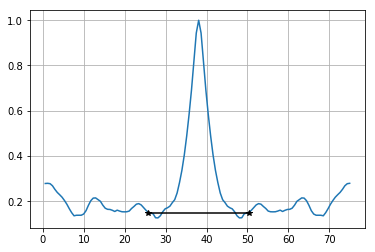

In [64]:
# Lengthscale in z at centerline

R11_mean = np.zeros([Nz])
for xi in range(0,Nx,int(Nx/10)):
    uhat = np.fft.fftshift(np.fft.fft(up[xi,Ny/2,:]))
    R11hat = uhat*np.conj(uhat)#autocorr
    R11 = np.abs(np.fft.ifft(R11hat))
    R11_mean += np.fft.ifftshift(R11)/R11.max()
R11_mean = R11_mean/R11_mean.max()

thresh = 0.15
i1 = np.argmin(abs(R11_mean[:Nz/2]-thresh))
i2 = np.argmin(abs(R11_mean[Nz/2:]-thresh)) + Nz/2
L = abs(zplot[i2]-zplot[i1])/2.
print("Integral Lz = {}".format(L))

plt.plot(zplot,R11_mean)
plt.plot([zplot[i1],zplot[i2]],[thresh,thresh],'k-*')
plt.grid(True)

# plt.xlim([-Ly/4,Ly/4])

1.0518867924528301


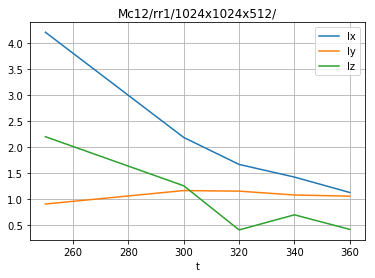

In [175]:
# Plot lengthscales normalized by dtheta

fname = filename_prefix+'lengthscales.dat'
dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
n = np.size(dat)

nstats=5
dat = np.reshape(dat,[n/nstats,nstats])
time = dat[:,0]
dtheta = dat[:,1]
lx = dat[:,2]
ly = dat[:,3]
lz = dat[:,4]

for i in range(len(time)):
    L99 =  L99_thickness(filename_prefix,time[i])
    lx[i] /= L99*2.
    ly[i] /= L99*2.
    lz[i] /= L99*2.
plt.figure()
plt.plot(time,lx,label='lx'); 
plt.plot(time,ly,label='ly'); 
plt.plot(time,lz,label='lz'); 
plt.grid(True)
plt.xlabel('t')
plt.title(directory.split('/production/')[-1])
plt.legend()

print(np.mean(ly[-1:]))
